# California Property Data

This notebook walks through reviewing California property data, splitting labeled data in train and test sets, gaining some intuition by plotting various charts from the input data, and then fitting the data with a ML model to predict housing prices.

## Import packages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import tarfile
import urllib
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Load and Analyze Data

In [2]:
HOUSING_PATH = "input-data/housing.csv"

In [3]:
def load_housing_data(housing_path=HOUSING_PATH):
    return pd.read_csv(housing_path)

Let's start with analyzing the data first

In [4]:
# Check the first 5 records from the housing data
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
# View info about the housing data
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
# List out the different values for "ocean proximity"
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
# View the stats for each attribute
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

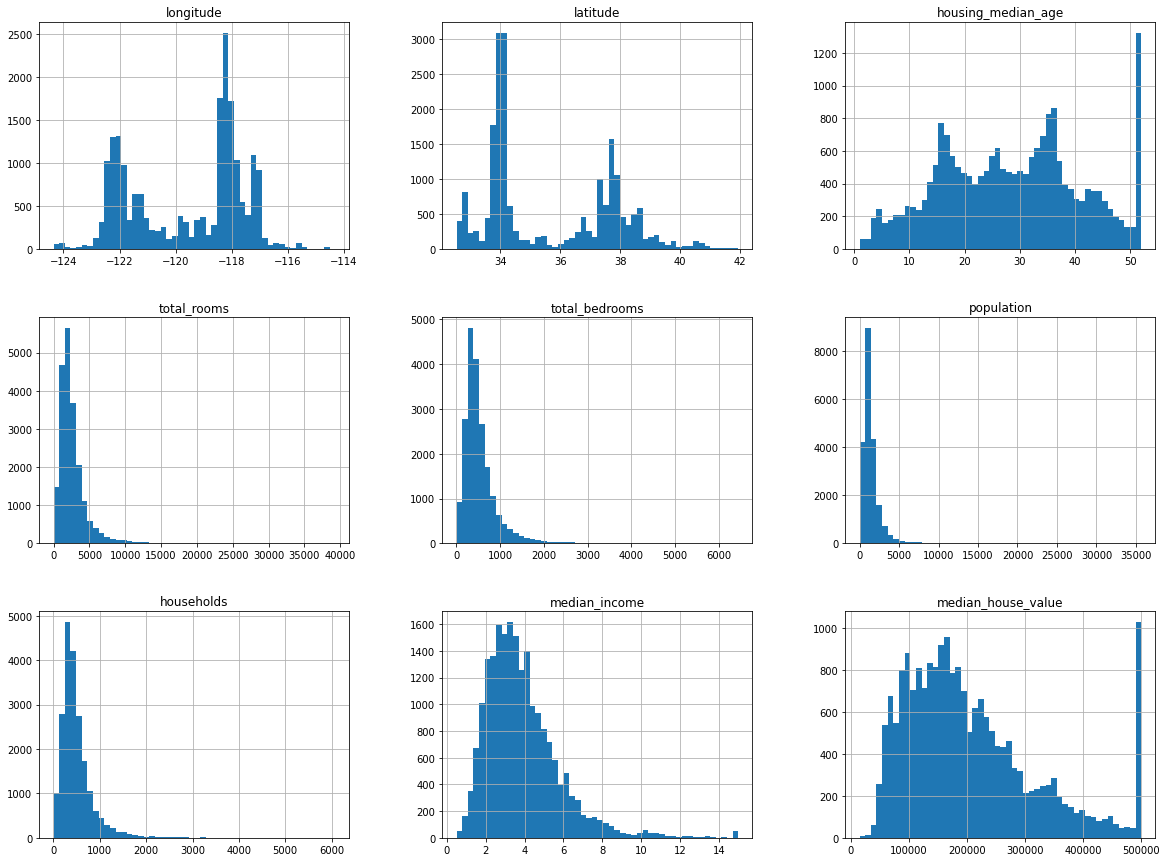

In [8]:
# plot histogram for all features
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))

**3. Split Data into Training and Test Set****

**Different Ways to Split Data into Training and Test Sets**

In [9]:
# create a test set
def split_train_set(data, test_ratio):
    shuffled_indices = np.random.permutations(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_set_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[-in_test_set], data.loc[in_test_set]

In [11]:
housing_with_id = housing.reset_index() # adds an index column
train_set, test_set = split_train_set_by_id(housing_with_id, 0.2, "index")

In [12]:
# split data using scikit
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [13]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 14196 to 15795
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


<AxesSubplot:>

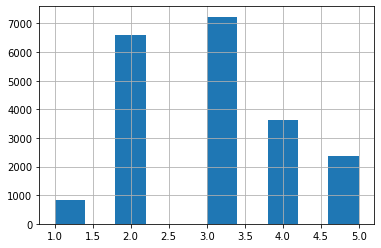

In [14]:
# create income category
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()


In [15]:
# stratified sampling based on income
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
split.split(housing, housing["income_cat"])

<generator object BaseShuffleSplit.split at 0x12d752ac0>

In [16]:
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [17]:
# remove the income_cat 

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Visualize the data

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

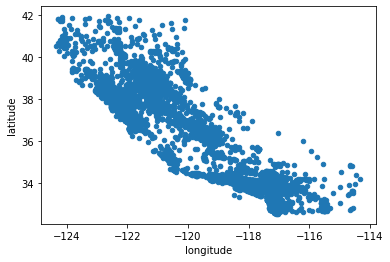

In [18]:
# make a copy of the train set
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude")


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

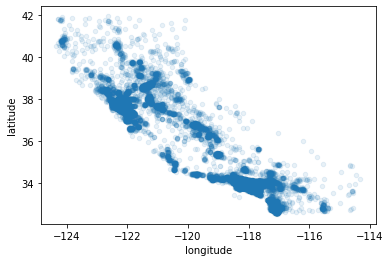

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

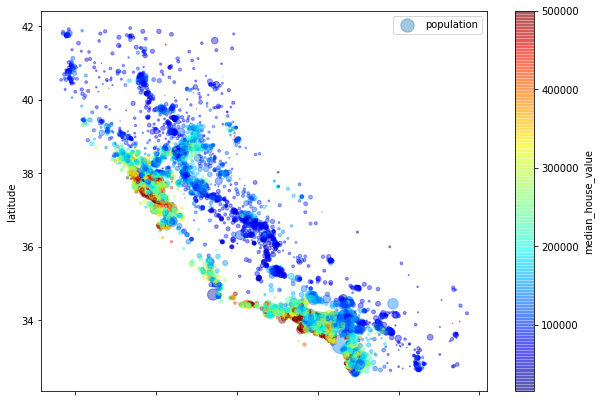

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
            s=housing["population"]/100, label="population", figsize=(10,7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

In [21]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

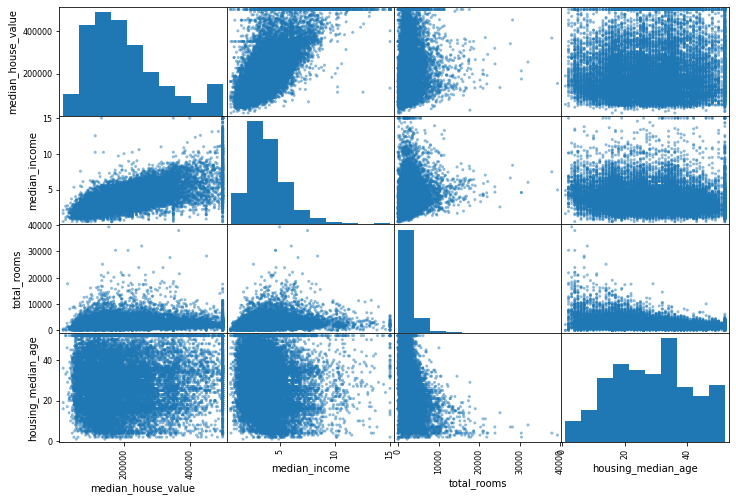

In [22]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

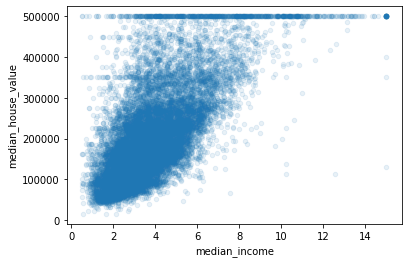

In [23]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [24]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [25]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='bedrooms_per_room', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='bedrooms_per_room', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='bedrooms_per_room'>,
        <AxesSubplot:xlabel='median_income', ylabel='bedrooms_per_room'>,
        <AxesSubplot:xlabel='bedrooms_per_room', ylabel='bedrooms_per_room'>]],
      dtype=object)

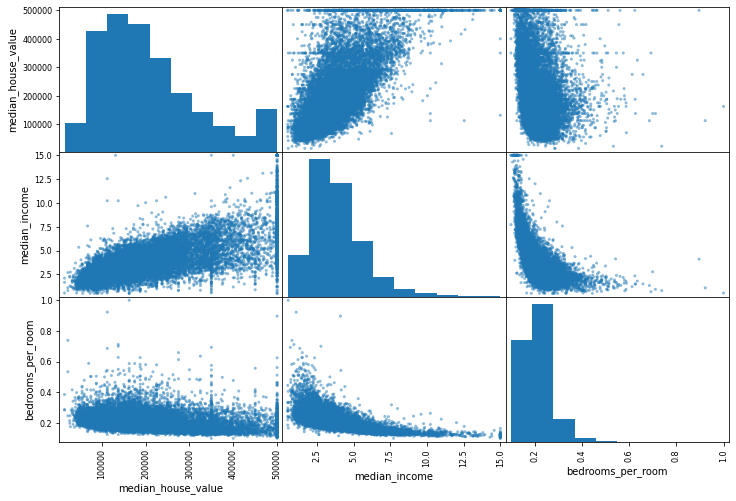

In [26]:
attributes = ["median_house_value", "median_income", "bedrooms_per_room"]
scatter_matrix(housing[attributes], figsize=(12,8))

<AxesSubplot:xlabel='bedrooms_per_room', ylabel='median_house_value'>

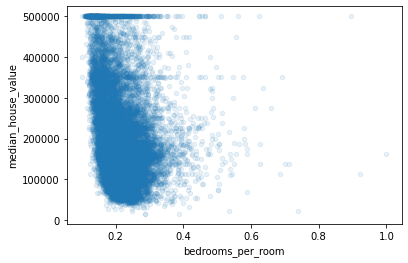

In [27]:
housing.plot(kind="scatter", x="bedrooms_per_room", y="median_house_value", alpha=0.1)

## Prepare the Data

In [28]:
# separate out predictors and labels
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Handle missing data in the training set

In [29]:
# handle missing data
# 1. get rid of the rows with missing "total_bedrooms"
# 2. get rid of the column "total_bedrooms"
# 3. replace missing data with median / mean etc

# housing.dropna(subset=["total_bedrooms"])
# housing.drop("total_bedrooms", axis=1)
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace=True)

In [30]:
# using SimpleImputer to replace na with "median"
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# median can only be calculated on numeric values, so copy the data without text attribute
housing_num = housing.drop("ocean_proximity", axis=1)

# calculate the median for all fields
imputer.fit(housing_num)

# view the median stored in imputer.statistics_
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [31]:
# check with manually calculated median value
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [32]:
# use the trained imputer to transform the training set by replacing the missing values with the learned median
X = imputer.transform(housing_num)
print(X)

[[-121.89     37.29     38.     ...  710.      339.        2.7042]
 [-121.93     37.05     14.     ...  306.      113.        6.4214]
 [-117.2      32.77     31.     ...  936.      462.        2.8621]
 ...
 [-116.4      34.09      9.     ... 2098.      765.        3.2723]
 [-118.01     33.82     31.     ... 1356.      356.        4.0625]
 [-122.45     37.77     52.     ... 1269.      639.        3.575 ]]


In [33]:
# the result is a numpy array. To transform it to a pandas Dataframe:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
print(housing_tr)

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
17606    -121.89     37.29                38.0       1568.0           351.0   
18632    -121.93     37.05                14.0        679.0           108.0   
14650    -117.20     32.77                31.0       1952.0           471.0   
3230     -119.61     36.31                25.0       1847.0           371.0   
3555     -118.59     34.23                17.0       6592.0          1525.0   
...          ...       ...                 ...          ...             ...   
6563     -118.13     34.20                46.0       1271.0           236.0   
12053    -117.56     33.88                40.0       1196.0           294.0   
13908    -116.40     34.09                 9.0       4855.0           872.0   
11159    -118.01     33.82                31.0       1960.0           380.0   
15775    -122.45     37.77                52.0       3095.0           682.0   

       population  households  median_income  
1760

### Handle Text and Categorical Attributes

In [34]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [35]:
housing_cat.ocean_proximity.value_counts()

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

In [36]:
# ML works better with numbers, so lets convert it these categories to numbers using OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded

array([[0.],
       [0.],
       [4.],
       ...,
       [1.],
       [0.],
       [3.]])

In [37]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [38]:
# one hot encode the categories
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [39]:
# convert sparse array to array
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [40]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers

In [41]:
housing.values

array([[-121.89, 37.29, 38.0, ..., 339.0, 2.7042, '<1H OCEAN'],
       [-121.93, 37.05, 14.0, ..., 113.0, 6.4214, '<1H OCEAN'],
       [-117.2, 32.77, 31.0, ..., 462.0, 2.8621, 'NEAR OCEAN'],
       ...,
       [-116.4, 34.09, 9.0, ..., 765.0, 3.2723, 'INLAND'],
       [-118.01, 33.82, 31.0, ..., 356.0, 4.0625, '<1H OCEAN'],
       [-122.45, 37.77, 52.0, ..., 639.0, 3.575, 'NEAR BAY']],
      dtype=object)

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin

room_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombineAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        rooms_per_household = X[:, room_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, room_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
    
attr_adder = CombineAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [43]:
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

### Feature Scaling and Transformation Pipeline

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("attribs_adder", CombineAttributesAdder()),
    ("std_scaler", StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [45]:
# using ColumnTransformer to transform numeric and categorical attributes

from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

## Select and Train a Model

### Training using Linear Regression

In [46]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [47]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [48]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [49]:
# RMSE
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

### Training using Decision Tree Regressor

In [50]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Cross Validation

Split the training set into smaller training set and a validation set, train the models against the smaller training set and evaluate against the validation set. 

In [51]:
# use K-fold cross validation to do cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [52]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70541.56963472 65674.63766825 69934.71654845 68917.04957165
 71137.69104448 75082.33317808 71603.75280604 71168.01619106
 76762.14619982 70139.5813719 ]
Mean: 71096.14942144613
Standard deviation: 2914.970077144871


In [53]:
# compute the scores for linear regression
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66755.35819855 66966.14573098 70347.95244419 74769.18698807
 68031.13388938 71229.17716103 64959.86064183 68270.70198961
 71552.91566558 67665.10082067]
Mean: 69054.75335298848
Standard deviation: 2744.2187083829585


### Training using Random Forest Regressor

In [54]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_reg_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, forest_reg_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18700.695931781338

In [55]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)


Scores: [49713.48124421 47940.01198511 49571.44094139 52249.77464345
 49457.43707391 53305.22069596 48540.83240454 47857.11230195
 52779.08617923 50379.05988774]
Mean: 50179.345735748124
Standard deviation: 1872.3286578093225


### Fine Tune Model

In [56]:
# use Grid Search to fine-tune hyper-parameters

from sklearn.model_selection import GridSearchCV

param_grid = [
    {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
    {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]},
]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                         scoring="neg_mean_squared_error",
                         return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [57]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [58]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [59]:
cvres = grid_search.cv_results_
cvres

{'mean_fit_time': array([0.08136311, 0.24101467, 0.74528432, 0.13279128, 0.46802669,
        1.30856423, 0.14724894, 0.5429781 , 2.23355279, 0.27539167,
        0.90864358, 1.91010985, 0.10516691, 0.33781114, 0.13894582,
        0.45638914, 0.16576138, 0.59644985]),
 'std_fit_time': array([0.00665271, 0.01269156, 0.0781985 , 0.0189768 , 0.09397245,
        0.18836478, 0.00418574, 0.08420542, 0.31010279, 0.03374358,
        0.0818296 , 0.05779768, 0.00426311, 0.00481186, 0.00587675,
        0.00875321, 0.00566644, 0.04274144]),
 'mean_score_time': array([0.00455065, 0.01176844, 0.03266315, 0.00600467, 0.0150423 ,
        0.03494225, 0.00452943, 0.01207128, 0.05337172, 0.00740304,
        0.01637497, 0.02957559, 0.00516114, 0.01275067, 0.00511255,
        0.01310124, 0.00456195, 0.0137507 ]),
 'std_score_time': array([0.0002769 , 0.0006474 , 0.00203564, 0.00144726, 0.00311659,
        0.00373225, 0.00071592, 0.00202527, 0.01396505, 0.00167393,
        0.00401738, 0.00057412, 0.00071762, 

In [60]:
cvres['mean_test_score']

array([-4.08884667e+09, -3.10865783e+09, -2.78757467e+09, -3.70779689e+09,
       -2.74519782e+09, -2.59286747e+09, -3.47448230e+09, -2.73183664e+09,
       -2.49597027e+09, -3.36453102e+09, -2.71903398e+09, -2.52096147e+09,
       -3.99904226e+09, -2.90546551e+09, -3.70055819e+09, -2.81766899e+09,
       -3.46920155e+09, -2.66202481e+09])

In [61]:
cvres['params']

[{'max_features': 2, 'n_estimators': 3},
 {'max_features': 2, 'n_estimators': 10},
 {'max_features': 2, 'n_estimators': 30},
 {'max_features': 4, 'n_estimators': 3},
 {'max_features': 4, 'n_estimators': 10},
 {'max_features': 4, 'n_estimators': 30},
 {'max_features': 6, 'n_estimators': 3},
 {'max_features': 6, 'n_estimators': 10},
 {'max_features': 6, 'n_estimators': 30},
 {'max_features': 8, 'n_estimators': 3},
 {'max_features': 8, 'n_estimators': 10},
 {'max_features': 8, 'n_estimators': 30},
 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3},
 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10},
 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3},
 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10},
 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3},
 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}]

In [62]:
tuple(zip(cvres['mean_test_score'], cvres['params']))

((-4088846671.8387322, {'max_features': 2, 'n_estimators': 3}),
 (-3108657826.9942093, {'max_features': 2, 'n_estimators': 10}),
 (-2787574672.38876, {'max_features': 2, 'n_estimators': 30}),
 (-3707796889.3889017, {'max_features': 4, 'n_estimators': 3}),
 (-2745197822.5771422, {'max_features': 4, 'n_estimators': 10}),
 (-2592867466.149454, {'max_features': 4, 'n_estimators': 30}),
 (-3474482299.5825567, {'max_features': 6, 'n_estimators': 3}),
 (-2731836639.188449, {'max_features': 6, 'n_estimators': 10}),
 (-2495970271.4812384, {'max_features': 6, 'n_estimators': 30}),
 (-3364531019.636032, {'max_features': 8, 'n_estimators': 3}),
 (-2719033981.854092, {'max_features': 8, 'n_estimators': 10}),
 (-2520961471.8053603, {'max_features': 8, 'n_estimators': 30}),
 (-3999042258.429686,
  {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}),
 (-2905465506.367602,
  {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}),
 (-3700558185.852193,
  {'bootstrap': False, 'max_features'

In [63]:
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63944.09020260381 {'max_features': 2, 'n_estimators': 3}
55755.33899990394 {'max_features': 2, 'n_estimators': 10}
52797.487368138645 {'max_features': 2, 'n_estimators': 30}
60891.68161078245 {'max_features': 4, 'n_estimators': 3}
52394.6354370096 {'max_features': 4, 'n_estimators': 10}
50920.20685493583 {'max_features': 4, 'n_estimators': 30}
58944.739371572054 {'max_features': 6, 'n_estimators': 3}
52266.97465119298 {'max_features': 6, 'n_estimators': 10}
49959.68646299973 {'max_features': 6, 'n_estimators': 30}
58004.57757484345 {'max_features': 8, 'n_estimators': 3}
52144.35714297466 {'max_features': 8, 'n_estimators': 10}
50209.177167180904 {'max_features': 8, 'n_estimators': 30}
63237.98113815531 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53902.37013682795 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60832.21338938928 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53081.71992856561 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

### Analyze the Best Models and Their Errors

In [64]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.09957338e-02, 6.21988880e-02, 4.33724422e-02, 1.74797296e-02,
       1.64773491e-02, 1.72727536e-02, 1.60613405e-02, 3.18998989e-01,
       5.72841458e-02, 1.09716010e-01, 9.53648687e-02, 7.21798766e-03,
       1.58432790e-01, 4.81323686e-05, 4.52352510e-03, 4.55531435e-03])

In [65]:
extra_attribs = ['room_per_hhold', 'pop_per_hhold', 'bedrooms_per_hhold']
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attribs = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attribs), reverse=True)

[(0.318998989382558, 'median_income'),
 (0.15843278986031054, 'INLAND'),
 (0.109716009888556, 'pop_per_hhold'),
 (0.09536486873470386, 'bedrooms_per_hhold'),
 (0.07099573375833063, 'longitude'),
 (0.062198888024584065, 'latitude'),
 (0.05728414581600672, 'room_per_hhold'),
 (0.04337244221372402, 'housing_median_age'),
 (0.017479729615052467, 'total_rooms'),
 (0.017272753558722573, 'population'),
 (0.016477349127020657, 'total_bedrooms'),
 (0.01606134054917271, 'households'),
 (0.007217987655574172, '<1H OCEAN'),
 (0.004555314345464116, 'NEAR OCEAN'),
 (0.004523525101576258, 'NEAR BAY'),
 (4.813236864307673e-05, 'ISLAND')]

## Evaluate on Test Set

In [66]:
final_model = grid_search.best_estimator_
final_model

RandomForestRegressor(max_features=6, n_estimators=30)

In [67]:
# split features and labels from test set
X_test = strat_test_set.drop("median_house_value", axis=1)
Y_test = strat_test_set["median_house_value"].copy()
print("X_test.info(): \n", X_test.describe(), "\nY_test.info(): \n ", Y_test.describe())

X_test.info(): 
          longitude     latitude  housing_median_age   total_rooms  \
count  4128.000000  4128.000000         4128.000000   4128.000000   
mean   -119.545187    35.600998           28.585029   2687.902132   
std       2.010260     2.127489           12.630172   2345.868226   
min    -124.180000    32.550000            1.000000      2.000000   
25%    -121.780000    33.920000           18.000000   1474.000000   
50%    -118.455000    34.220000           28.000000   2158.500000   
75%    -117.980000    37.690000           37.000000   3171.000000   
max    -114.560000    41.950000           52.000000  32627.000000   

       total_bedrooms    population  households  median_income  
count     4079.000000   4128.000000  4128.00000    4128.000000  
mean       549.484187   1448.220446   509.45688       3.850998  
std        454.414696   1197.088364   407.59254       1.879270  
min          1.000000      5.000000     1.00000       0.499900  
25%        301.000000    805.750000 

In [68]:
# transform features
X_test_prepared = full_pipeline.transform(X_test)

In [69]:
# predict
final_predictions = final_model.predict(X_test_prepared)

In [70]:
# compute root mean squared error
final_mse = mean_squared_error(Y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48744.386983962395

### A full pipeline with prep and prediction

In [71]:
final_model

RandomForestRegressor(max_features=6, n_estimators=30)

In [72]:
full_pipeline_with_predictor = Pipeline([
    ("preparation", full_pipeline),
    ("random_forest", final_model)
])

full_pipeline_with_predictor.fit(housing, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombineAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                     

In [73]:
#X_test_prepared[1]
prediction = full_pipeline_with_predictor.predict(X_test)

In [74]:
final_mse = mean_squared_error(Y_test, prediction)
final_rmse = np.sqrt(final_mse)
final_rmse

47515.66822302427

## Save Model

In [75]:
my_model = full_pipeline_with_predictor

In [76]:
import joblib
joblib.dump(my_model, "my_model.pkl")

['my_model.pkl']

In [77]:
my_model_loaded = joblib.load("my_model.pkl")

In [78]:
prediction = my_model_loaded.predict(X_test)

In [79]:
final_mse = mean_squared_error(Y_test, prediction)
final_rmse = np.sqrt(final_mse)
final_rmse

47515.66822302427

## Additional Models

### Support Vector Machine Regressor

In [80]:
from sklearn.svm import SVR

svr_reg = SVR()
svr_reg.fit(housing_prepared, housing_labels)
svr_reg_predictions = svr_reg.predict(housing_prepared)
svr_mse = mean_squared_error(housing_labels, svr_reg_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

118580.68301157995

In [81]:
# Use GridSearchCV to try different hyperparameter values
svr_param_grid = [
    {'kernel': ['linear'], 'C': [10000., 30000.]},
    #{'kernel' : ['rbf'], 'C': [1., 3., 10., 30., 100., 300., 1000., 3000.], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
]

svr_grid_search = GridSearchCV(svr_reg, svr_param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, verbose=2)
svr_grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] C=10000.0, kernel=linear ........................................
[CV] ......................... C=10000.0, kernel=linear, total=  10.3s
[CV] C=10000.0, kernel=linear ........................................
[CV] ......................... C=10000.0, kernel=linear, total=  13.7s
[CV] C=10000.0, kernel=linear ........................................
[CV] ......................... C=10000.0, kernel=linear, total=  20.0s
[CV] C=10000.0, kernel=linear ........................................
[CV] ......................... C=10000.0, kernel=linear, total=  13.0s
[CV] C=10000.0, kernel=linear ........................................
[CV] ......................... C=10000.0, kernel=linear, total=  12.0s
[CV] C=30000.0, kernel=linear ........................................
[CV] ......................... C=30000.0, kernel=linear, total=  18.7s
[CV] C=30000.0, kernel=linear ........................................
[CV] ............

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.3min finished


GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10000.0, 30000.0], 'kernel': ['linear']}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [82]:
svr_grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

In [83]:
svr_grid_search.best_estimator_

SVR(C=30000.0, kernel='linear')

In [84]:
svr_cvres = svr_grid_search.cv_results_
svr_cvres

{'mean_fit_time': array([12.81926126, 17.63540654]),
 'std_fit_time': array([3.11379193, 0.94184132]),
 'mean_score_time': array([0.98573117, 0.83932319]),
 'std_score_time': array([0.28193405, 0.10112937]),
 'param_C': masked_array(data=[10000.0, 30000.0],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['linear', 'linear'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 10000.0, 'kernel': 'linear'},
  {'C': 30000.0, 'kernel': 'linear'}],
 'split0_test_score': array([-4.57506323e+09, -4.57570050e+09]),
 'split1_test_score': array([-5.46873212e+09, -5.47299547e+09]),
 'split2_test_score': array([-5.05690481e+09, -5.05205019e+09]),
 'split3_test_score': array([-4.63400708e+09, -4.63358928e+09]),
 'split4_test_score': array([-5.02833286e+09, -5.02101450e+09]),
 'mean_test_score': array([-4.95260802e+09, -4.95106999e+09]),
 'std_test_score': array([3.24666842

In [85]:
for mean_score, params in zip(svr_cvres['mean_test_score'], svr_cvres['params']):
    print(np.sqrt(-mean_score), params)

70374.76833985467 {'C': 10000.0, 'kernel': 'linear'}
70363.84006944533 {'C': 30000.0, 'kernel': 'linear'}


In [88]:
# use RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_distribs = {
    'kernel': ['linear', 'rbf'],
    'C': reciprocal(20, 200000),
    'gamma': expon(scale=1.0),
}

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs, 
                                n_iter=50, cv=5, 
                                scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)



Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.8s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   8.6s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.2s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   8.3s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   8.6s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  18.8s
[CV] C=26290.206464300216, gamma

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 70.7min finished


RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x13137a190>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x13135c8b0>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [89]:
rnd_search.best_estimator_

SVR(C=157055.10989448498, gamma=0.26497040005002437)

In [90]:
rnd_search.best_score_

-2999529520.3413205

```
full_pipeline_with_predictor_svm = Pipeline([
    ("preparation", full_pipeline),
    ("svm", rnd_search.best_estimator_)
])
```

